
Traffic Signs Machine Learning Report

Dataset: https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification/data?select=labels.csv

By: Christopher Heimbuch

## <b>Overview</b>

In the last notebook, I explored some of the qualities of the dataset. I explored image classes and dimensionality exploration. I observed the height, widths, aspect ratios, and RGB intensity distribution of the image dataset. The majority of images seem to have a height and width of roughly 140 pixels, with many falling outside of that range. Additionally, after observing the RGB intensity of the images, it appears red has the highest intensity among the images. As I delve deeper into the machine learning approach and neural network approach, I expect classic machine learning will not be accurate at identifying the images correctly and will have pretty bad accuracy. Neural networks and deep learning will most likely be employed here to identify meaningful heurstics and patterns within the data.

# Section 1: Data Preprocessing

In [90]:
#Importing in libraries to work with the image data.

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns 
from PIL import Image as Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


from skimage.feature import hog
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, explained_variance_score, r2_score, mean_absolute_error

# Machine Learning Algorithms
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, ExtraTreesRegressor

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#Going to prepare image data to work with. I will first handle the training data.

#Setting directories for my images.

input_dir_train = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\DATA"
input_dir_test = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\TEST"

In [54]:
#Here I am extracting out the images from my DATA folder, and adding them to the "image" variable. 
#By default, cv2 stores image in BGR format, in which to display some images, I will need to convert them to RGB.

image_list = os.listdir(input_dir_train)
counter = 0
image = []
class_number = []

for i in range(0, len(mylist)):
    pictures = os.listdir(input_dir_train + "/" + str(counter))

    for img in pictures:
        current = cv2.imread(input_dir_train + "/" + str(counter) + "/" + img)
        image.append(current)
        class_number.append(counter)
    counter = counter + 1

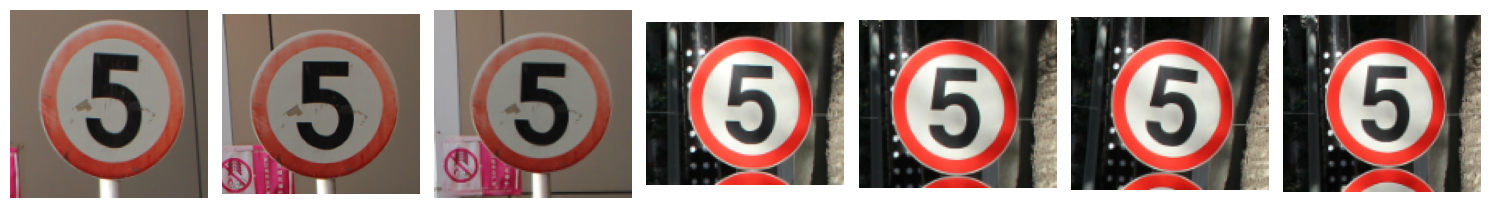

In [57]:
#Inspect a few images in the image list

fig, ax = plt.subplots(1, 7, figsize=(15, 5))

# Convert and display the images in each subplot
for i in range(7):
    image_rgb = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB) 
    ax[i].imshow(image_rgb)
    ax[i].axis('off')  

# Display the plot
plt.tight_layout()
plt.show()

In [14]:
#Going to prepare image data to work with. I will first handle the training data.

image_data = []
labels = []

#Create a loop to go through each class folder
for label_folder in os.listdir(input_dir_train):
    folder_path = os.path.join(input_dir_train, label_folder)

    #Check to see if the folder is an actual directory.
    if os.path.isdir(folder_path):
        #here we will loop through each image in the given class folder (Class folders are named 0 - 57)
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

        #read the image in color.
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)

        #this will only proceed if the image exists
        if img is not None:
            #resize image to fixed size so its uniform ( as most images had different heights and widths)
            img_resized = cv2.resize(img, (32,32))

            #make image interpretable for machine models by flattening it into a 1D array.
            img_flattened = img_resized.flatten()

            #add the flattened image and the label to the lists above that we instantiated.
            image_data.append(img_flattened)
            labels.append(int(label_folder))
        else:
            print(f"The image could not be read {image_path}")

#convert the lists into numpy arrays for efficiency
image_data = np.array(image_data)
labels = np.array(labels)


In [82]:
#Convert image data to a DataFrame
df = pd.DataFrame(image_data)

#Scale data so it is more managable for machine models.
df = df / 255

# Add the labels as the target column
df['label'] = labels

df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,0.831373,0.850980,0.835294,0.858824,0.854902,0.843137,0.729412,0.721569,0.698039,0.572549,...,0.172549,0.172549,0.215686,0.250980,0.250980,0.266667,0.298039,0.309804,0.329412,0
1,0.360784,0.345098,0.341176,0.349020,0.325490,0.321569,0.337255,0.313725,0.294118,0.325490,...,0.074510,0.098039,0.090196,0.066667,0.098039,0.078431,0.090196,0.117647,0.098039,1
2,0.192157,0.188235,0.121569,0.188235,0.180392,0.176471,0.635294,0.572549,0.560784,0.635294,...,0.549020,0.525490,0.509804,0.662745,0.639216,0.623529,0.329412,0.305882,0.290196,10
3,0.380392,0.435294,0.474510,0.439216,0.478431,0.517647,0.439216,0.490196,0.537255,0.403922,...,0.101961,0.101961,0.113725,0.094118,0.101961,0.109804,0.062745,0.070588,0.082353,11
4,0.619608,0.619608,0.619608,0.623529,0.619608,0.627451,0.623529,0.615686,0.619608,0.549020,...,0.411765,0.439216,0.450980,0.290196,0.321569,0.345098,0.168627,0.172549,0.184314,12


In [84]:
#Going to create a function for "Shotgun approach" for machine learning modeling.

def classification_model_test(model, X_train, y_train, X_test, y_test):
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Generate heatmap of confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),
            annot=True,
            cmap="coolwarm",
            square=True)

    # Print classification report
    print(classification_report(y_true=y_test, y_pred=y_pred))

    return f"Accuracy Score: {accuracy:.2f}"

In [74]:
X = df.drop(columns=['label'])
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          20       0.00      0.00      0.00       1.0
          29       0.00      0.00      0.00       0.0
          31       0.00      0.00      0.00       1.0
          34       0.00      0.00      0.00       0.0
          36       0.00      0.00      0.00       0.0
          37       0.00      0.00      0.00       0.0
          42       0.00      0.00      0.00       1.0
          43       0.00      0.00      0.00       0.0
          44       0.00      0.00      0.00       0.0
          45       0.00      0.00      0.00       0.0
          49       0.00    

'Accuracy Score: 0.00'

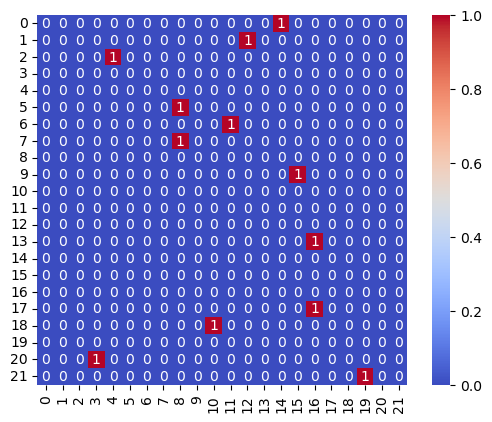

In [91]:
log_reg = LogisticRegression()
classification_model_test(log_reg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          20       0.00      0.00      0.00       1.0
          31       0.00      0.00      0.00       1.0
          34       0.00      0.00      0.00       0.0
          42       0.00      0.00      0.00       1.0
          49       0.00      0.00      0.00       1.0
          50       0.00      0.00      0.00       1.0
          52       0.00      0.00      0.00       1.0
          56       0.00    

'Accuracy Score: 0.00'

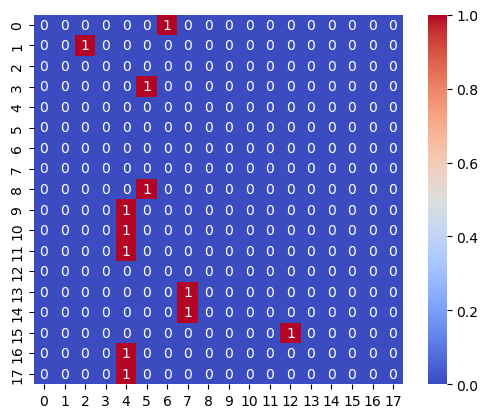

In [92]:
knn_model = KNeighborsClassifier()
classification_model_test(knn_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          20       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       0.0
          29       0.00      0.00      0.00       0.0
          31       0.00      0.00      0.00       1.0
          36       0.00      0.00      0.00       0.0
          37       0.00      0.00      0.00       0.0
          40       0.00      0.00      0.00       0.0
          42       0.00      0.00      0.00       1.0
          44       0.00      0.00      0.00       0.0
          45       0.00      0.00      0.00       0.0
          49       0.00    

'Accuracy Score: 0.00'

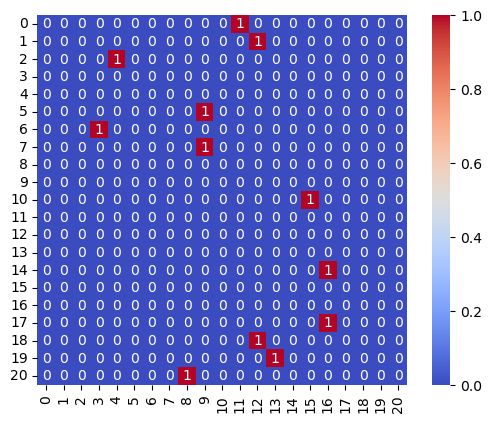

In [93]:
svc_model = SVC()
classification_model_test(svc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       1.0
          14       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00       0.0
          20       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       0.0
          31       0.00      0.00      0.00       1.0
          37       0.00      0.00      0.00       0.0
          42       0.00      0.00      0.00       1.0
          47       0.00      0.00      0.00       0.0
          49       0.00      0.00      0.00       1.0
          50       0.00      0.00      0.00       1.0
          52       0.00    

'Accuracy Score: 0.00'

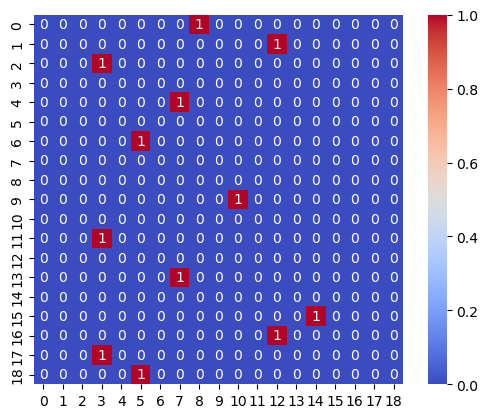

In [94]:
gbc_model = GradientBoostingClassifier()
classification_model_test(gbc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          20       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       0.0
          29       0.00      0.00      0.00       0.0
          31       0.00      0.00      0.00       1.0
          34       0.00      0.00      0.00       0.0
          35       0.00      0.00      0.00       0.0
          42       0.00      0.00      0.00       1.0
          49       0.00      0.00      0.00       1.0
          50       0.00      0.00      0.00       1.0
          52       0.00      0.00      0.00       1.0
          56       0.00    

'Accuracy Score: 0.00'

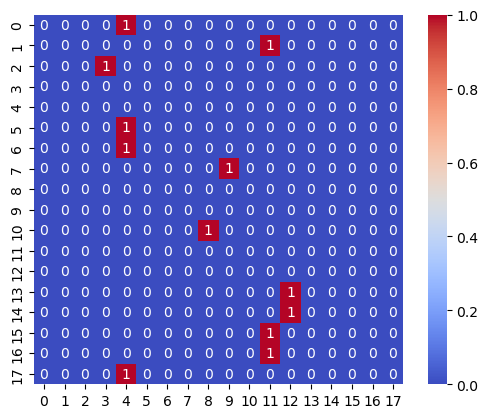

In [96]:
sgd_model = SGDClassifier()
classification_model_test(sgd_model, X_train, y_train, X_test, y_test)